###  Chemiscope Auto

In [31]:
import ase.io
from mace.calculators import mace_off
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import chemiscope

Install MACE and Chemiscope

In [11]:
! pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
! pip install mace-torch
! pip install chemiscope

Looking in indexes: https://download.pytorch.org/whl/cu118


Load QM9

In [23]:
from load_atoms import load_dataset

dataset = load_dataset("QM9")
frames = dataset[:100]

Output()

Computation of MACE features

In [24]:
descriptor_opt = {"model": "small", "device": "cpu"}
calculator = mace_off(**descriptor_opt)

Using MACE-OFF23 MODEL for MACECalculator with /home/chorna/.cache/mace/MACE-OFF23_small.model
Using float64 for MACECalculator, which is slower but more accurate. Recommended for geometry optimization.


In [27]:
descriptors = []

for frame in tqdm(frames):
    structure_avg = np.mean(
        calculator.get_descriptors(frame, invariants_only=True), axis=0
    )
    descriptors.append(structure_avg)

descriptors = np.array(descriptors)

  0%|          | 0/100 [00:00<?, ?it/s]

Save the computed MACE features for future use

In [28]:
np.save("./data/descriptors_MACE_OFF_small.npy", descriptors)

Perform PCA on the MACE features

Text(0.5, 1.0, 'PCA of MACE Features')

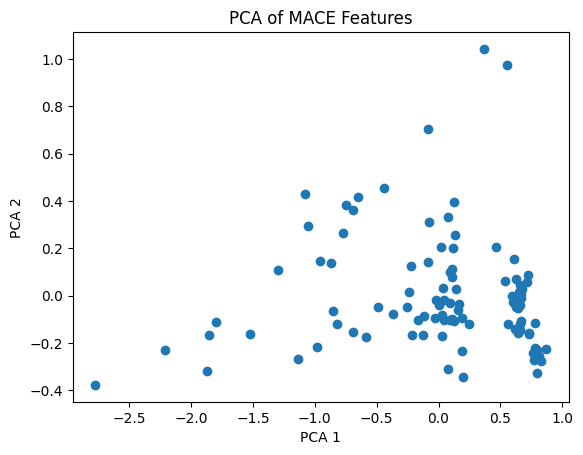

In [37]:
from sklearn.decomposition import PCA

X_pca = PCA(n_components=2).fit_transform(descriptors)

plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of MACE Features")

Extract QM9 properties, for example HOMO-LUMO gap

In [63]:
properties = {"homo": [], "lumo": [], "gap": []}
for frame in frames:
    properties["homo"].append(frame.info["homo"])
    properties["lumo"].append(frame.info["lumo"])
    properties["gap"].append(frame.info["gap"])

# Normalizing properties for better visualization
properties["homo"] = (
    np.array(properties["homo"]) - np.mean(properties["homo"])
) / np.std(properties["homo"])
properties["lumo"] = (
    np.array(properties["lumo"]) - np.mean(properties["lumo"])
) / np.std(properties["lumo"])
properties["gap"] = (np.array(properties["gap"]) - np.mean(properties["gap"])) / np.std(
    properties["gap"]
)

Add QM9 properties to the PCA visualization

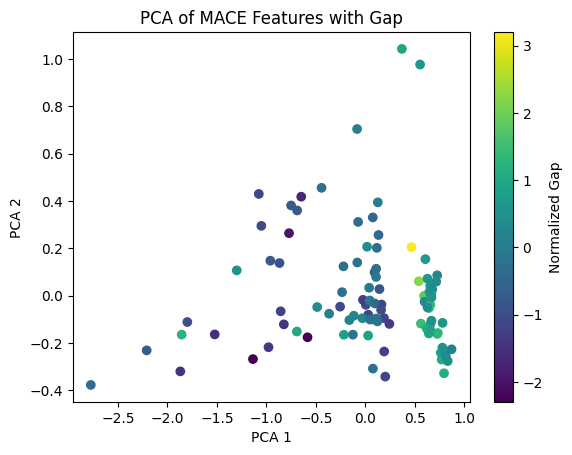

In [70]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=properties["gap"], cmap="viridis")
plt.colorbar(label="Normalized Gap")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("PCA of MACE Features with Gap")
plt.show()

Chemiscope Visualisation

In [69]:
metadata = {
    "name": "QM9 MACE features",
}

cs = chemiscope.show(
    frames=frames,
    properties={
        "PCA 1": {"target": "structure", "values": X_pca[:, 0].tolist()},
        "PCA 2": {"target": "structure", "values": X_pca[:, 1].tolist()},
        "homo": {"target": "structure", "values": properties["homo"].tolist()},
        "lumo": {"target": "structure", "values": properties["lumo"].tolist()},
        "gap": {"target": "structure", "values": properties["gap"].tolist()},
    },
    meta=metadata,
)

cs

<ChemiscopeWidget(meta={'name': 'QM9 MACE features'}, structures=[{'size': 5, 'names': ['C', 'H', 'H', 'H', 'H…